In [ ]:
#|default_exp callback.ema

In [ ]:
#|exporti
# EMA Callbacks are inspired by timm's ModelEmaV2: https://github.com/rwightman/pytorch-image-models/blob/main/timm/utils/model_ema.py
# PyTorch Image Models - Apache License 2.0 - Copyright (c) 2020 Ross Wightman

# Exponential Moving Average
> Exponential Moving Average (EMA) of model weights with a fused update step

In [ ]:
#|export
from __future__ import annotations

from copy import deepcopy

from fastai.callback.core import Callback
from fastai.callback.fp16 import MixedPrecision
from fastai.callback.schedule import SchedCos, _Annealer

from fastxtend.imports import *

`EMACallback` and `EMAWarmupCallback` have a fast fused implementation using PyTorch ForEach methods from PyTorch's [`_multi_tensor`](https://github.com/pytorch/pytorch/tree/master/torch/optim) optimizers. The fused EMA step is 1 to 8.4 times faster[^faster] than a standard Python EMA step via a for loop.

| Model             | For Loop Step | ForEach Step | Speedup |
| :---------------: | :-----------: | :----------: | :-----: |
| XResNet50         | 8.04µs        | 2.37µs       | 2.3x    |
| XSE-ResNeXt50     | 10.7µs        | 2.34µs       | 3.5x    |
| XResNet101        | 15.3µs        | 4.27µs       | 2.5x    |
| ConvNeXt Tiny     | 8.14µs        | 963ns        | 7.4x    |
| ViT Patch16 Small | 7.37µs        | 778ns        | 8.4x    |
| DeBERTa Base      | 10.0µs        | 4.79µs       | 1.0x    |

: For Loop EMA Step vs Fused ForEach EMA Step {#tbl-fused}

[^faster]: `EMACallback` performance was benchmarked on a GeForce 3080 Ti using PyTorch 1.13.1, Cuda 11.7, Mixed Precision, and [Channels Last](callback.channelslast.html) (except DeBERTa and ViT). Results may differ on other models, hardware, and across benchmarking runs. Speedup is calculated from the total time spent on the EMA step.

## EMACallback -

In [ ]:
#|export
class EMACallback(Callback):
    "Exponential Moving Average (EMA) of model weights with a fused update step"
    order,run_valid = MixedPrecision.order+1,False
    def __init__(self,
        decay:float=0.9998, # EMA decay value
        start:Numeric=0, # Start EMA in percent of training steps (float) or epochs (int, index 0)
        ema_device:torch.device|str|None=None, # Device to store EMA weights. Defaults to model device
        validate_ema:bool=True, # Run validation metrics using EMA weights instead of model weights. If true, `ema_device` must match model device
        replace_weights:bool=False, # Replace model weights with EMA weights when finished training. If false, sets `Learner.model_ema` to EMA weights
        foreach:bool|None=None, # Fuse EMA update step with PyTorch ForEach methods or use a standard for loop. Defaults to true if PyTorch 1.12+ and Cuda device detected
        resume:bool=False, # Resume from EMA weights from previous training saved to `Learner.model_ema`
        all_parameters:bool=False, # Apply EMA step to all parameters or only those with `requires_grad`
        all_buffers:bool=False, # Apply EMA step to persistent model buffers or all buffers
        skip_ema:bool=True, # Skip EMA step if callbacks, such as GradientAccumulation or MixedPrecision, skip the Optimizer update step
    ):
        store_attr()
        self.inverse_decay = 1-decay
        if self.foreach is None and ema_device is None:
            self.foreach = ismin_torch('1.12') and torch.cuda.is_available()

        if self.foreach:
            if notmax_torch('1.12'):
                warn(f'EMACallback with foreach=True is untested on PyTorch {torch.__verson__}, recommended to use 1.12 or newer')

        if resume and self.start > 0:
            warn(f'Resuming from prior EMA weights but delaying EMA until {start=}')

    @torch.no_grad()
    def before_fit(self):
        if hasattr(self.learn, 'lr_finder') or hasattr(self.learn, "gather_preds"):
            self.run = False
            return

        self._do_ema, self._restore_ema = False, False

        if self.start >= 1 and isinstance(self.start, int):
            self.start = self.start/self.n_epoch
        if self.start >= 1:
            warn(f'EMA start {self.start} is equal or greater than one and will not start in this training run')

        if self.resume:
            self.ema_model = self.learn.model_ema.eval()
        else:
            self.ema_model = deepcopy(self.learn.model).eval()

        model_device = next(self.learn.model.parameters()).device
        self.ema_model.to(self.ema_device if self.ema_device is not None else model_device)
        ema_device = next(self.ema_model.parameters()).device

        self.model_tensors, self.ema_tensors = [], []
        for mt, et in zip(self.learn.model.parameters(), self.ema_model.parameters()):
            if self.all_parameters or mt.requires_grad:
                self.model_tensors.append(mt)
                self.ema_tensors.append(et)

        self.model_buffers, self.ema_buffers = [], []
        state_names = self.model.state_dict().keys()
        for (n, mb), (_, eb) in zip(self.learn.model.named_buffers(), self.ema_model.named_buffers()):
            if self.all_buffers or n in state_names:
                # foreach methods cannot convert non-floats back to original type and error out
                if self.foreach and torch.is_floating_point(mb):
                    self.model_tensors.append(mb)
                    self.ema_tensors.append(eb)
                else:
                    self.model_buffers.append(mb)
                    self.ema_buffers.append(mb)

        self._validate_ema = model_device == ema_device if self.validate_ema else False
        if self.foreach:
            assert model_device == ema_device, f"{ema_device=} must equal {model_device=} if using foreach"

    @torch.no_grad()
    def before_batch(self):
        if self.pct_train >= self.start:
            if self.start > 0 and not self._do_ema and not self.resume:
                self.ema_model.load_state_dict(self.learn.model.state_dict())
            self._do_ema = True

    def after_cancel_batch(self):
        # if a callback (such as GradientAccumulation) raises a CancelBatchException, don't do EMA step and potentially turn EMA back on
        if self.skip_ema:
            self._restore_ema = self._do_ema
            self._do_ema = False

    def after_cancel_step(self):
        # if a callback (such as MixedPrecision) raises a CancelStepException, don't do EMA step and potentially turn EMA back on
        if self.skip_ema:
            self._restore_ema = self._do_ema
            self._do_ema = False

    @torch.no_grad()
    def after_batch(self):
        if self._do_ema:
            if self.foreach:
                torch._foreach_mul_(self.ema_tensors, scalar=self.decay)
                torch._foreach_add_(self.ema_tensors, self.model_tensors, alpha=self.inverse_decay)
                # foreach methods cannot convert non-floats back to original type and error out
                for mb, eb in zip(self.model_buffers, self.ema_buffers):
                    eb.copy_(self.decay * eb + self.inverse_decay * mb)
            else:
                for mt, et in zip(self.model_tensors, self.ema_tensors):
                    et.copy_(self.decay * et + self.inverse_decay * mt)
        # handle a Cancel Exception while self._do_ema was set to True
        if self._restore_ema:
            self._do_ema = True
            self._restore_ema = False

    @torch.no_grad()
    def before_validate(self):
        if self._do_ema and self._validate_ema:
            self.temp_model = self.learn.model
            self.learn.model = self.ema_model

    @torch.no_grad()
    def after_validate(self):
        if self._do_ema and self._validate_ema:
            self.learn.model = self.temp_model

    def after_fit(self):
        if self.replace_weights:
            self.learn.model = self.ema_model
            self.ema_model = None
        else:
            self.learn.model_ema = self.ema_model

`EMACallback` is inspired by [`ModelEmaV2`](https://github.com/rwightman/pytorch-image-models/blob/main/timm/utils/model_ema.py) from PyTorch Image Model (timm), and should match the [TensorFlow EMA implementation](https://www.tensorflow.org/api_docs/python/tf/train/ExponentialMovingAverage).

The `ema_decay` default of 0.9998 means each EMA model update `EMACallback` will keep 99.98% of the prior EMA weights and update 0.02% towards the training model weights.

To prevent `EMACallback` from using GPU memory, set `device='cpu'`. EMA validation will need to be performed manually post-training or via a custom callback.

To use the fused EMA step, set `foreach=True`. Likewise set to false to disable. `EMACallback` will automatically select the fused method if using PyToch 1.12+, a Cuda device is detected, and foreach is the default of `foreach=None`.

If `all_parameters=False`, only parameters with [`requires_grad`](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html#torch.Tensor.requires_grad) are included in the EMA calculation.

If `all_buffers=False`, only persistent [buffers](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_buffer) are included in the EMA calculation.

If `skip_ema=True` (the default), then the EMA calculation will not apply if any other callback raises a `CancelBatchException` or `CancelStepException`. This is intended to handle the `fastai.callback.fp16.MixedPrecision` AMP scaler and `fastai.callback.training.GradientAccumulation` skipping the optimizer update step, which means the model weights won't have changed so the EMA step should not be calculated. If needed this behavior can be turned off. In general, this argument should be left unchanged.

## EMAWarmupCallback -

In [ ]:
#|export
class EMAWarmupCallback(EMACallback):
    "Exponential Moving Average (EMA) of model weights with a warmup schedule and fused update step"
    order,run_valid = MixedPrecision.order+1,False
    def __init__(self,
        start_decay:float=0.9, # Initial EMA decay value
        final_decay:float=0.9998, # Final EMA decay value
        start:Numeric=0, # Start EMA warmup in percent of training steps (float) or epochs (int, index 0)
        finish:Numeric=0.3, # Finish EMA warmup in percent of training steps (float) or epochs (int, index 0)
        schedule:Callable[..., _Annealer]=SchedCos, # EMA decay warmup schedule
        ema_device:torch.device|str|None=None, # Device to store EMA weights. Defaults to model device
        validate_ema:bool=True, # Run validation metrics using EMA weights instead of model weights. If true, `ema_device` must match model device
        replace_weights:bool=False, # Replace model weights with EMA weights when finished training. If false, set `Learner.model_ema` to EMA weights
        foreach:bool|None=None, # Fuse EMA update step with PyTorch ForEach methods or use a standard for loop. Defaults to true if PyTorch 1.12+ and Cuda device detected
        resume:bool=False, # Resume from EMA weights from previous training saved to `Learner.model_ema`
        all_parameters:bool=False, # Apply EMA step to all parameters or only those with `requires_grad`
        all_buffers:bool=False, # Apply EMA step to persistent model buffers or all buffers
        skip_ema:bool=True, # Skip EMA step if callbacks, such as GradientAccumulation or MixedPrecision, skip the Optimizer update step
        logger_callback:str='wandb', # Log EMA decay to `logger_callback` using `Callback.name` if available
    ):
        super().__init__(decay=final_decay, start=start, ema_device=ema_device,
                         validate_ema=validate_ema, replace_weights=replace_weights,
                         foreach=foreach, resume=resume, all_parameters=all_parameters,
                         all_buffers=all_buffers, skip_ema=skip_ema)
        store_attr(names='start_decay,final_decay,finish,logger_callback')
        self.schedule = schedule(start_decay, final_decay)

    def before_fit(self):
        if self.finish - self.start <= 0:
            warn(f'EMA Warmup start={self.start} is less or equal to final={self.epoch} which negates warmup')

        super().before_fit()

        if self.finish >= 1 and isinstance(self.finish, int):
            self.finish = self.finish/self.n_epoch
        if self.finish >= 1:
            warn(f'EMA Warmup finish {self.finish} is equal or greater than one and will not finish in this training run')

        if self.resume and self.n_epoch < self.finish*self.n_epoch:
            warn("Resuming EMA Warmup before the warmup is finished is not supported")

        # negate decay so at least one ema scheduling step will occur
        self.decay = -1*self.decay
        self.warmup_pct = 0.
        self._warmup_sched = 1/(len(self.dls.train) * self.n_epoch * (self.finish - self.start))

        self._log_ema_decay = getattr(self, f'_{self.logger_callback}_log_ema_decay', noop)
        self.has_logger = hasattr(self.learn, self.logger_callback) and self._log_ema_decay != noop

    def after_batch(self):
        if self._do_ema:
            if self.pct_train >= self.start and self.decay != self.final_decay:
                if self.pct_train >= self.finish:
                    self.decay = self.final_decay
                else:
                    self.decay = self.schedule(self.warmup_pct)
                    self.warmup_pct += self._warmup_sched
                self.inverse_decay = 1-self.decay

            super().after_batch()

        if self.has_logger:
            if self._do_ema:
                self._log_ema_decay(self.decay)
            else:
                self._log_ema_decay(0.)

`EMAWarmupCallback` extends `EMACallback` by adding a schedulable EMA decay value from an initial value of `start_decay` to `final_decay` for the rest of training. The change in the EMA decay occurs between `start_epoch` and `final_epoch`.

The EMA warmup `schedule` can be one of [`SchedCos`](https://docs.fast.ai/.html#schedcos) (the default), [`SchedLin`](https://docs.fast.ai/callback.schedule.html#schedlin), [`SchedExp`](https://docs.fast.ai/callback.schedule.html#schedexp), [`SchedPoly`](https://docs.fast.ai/callback.schedule.html#schedpoly), or a custom [fastai annealer](https://docs.fast.ai/callback.schedule.html#annealer) based schedule. `SchedPoly` must be passed as partial function: `partial(SchedPoly, power=0.5)`.

::: {.callout-warning}
<code>EMAWarmupCallback</code> does not support resumed training while EMA warmup is in progress. This is due to fastai not fully supporting resumable training.
:::

`EMAWarmupCallback` can resume training after the warmup period as finished.

## Weights & Biases Logging

If Weights & Biases is installed and the [`WandbCallback`](https://docs.fast.ai/callback.wandb.html) is added to `Learner`, `EMAWarmupCallback` will automatically log the current EMA decay rate to Weights & Biases as `ema_decay`.

## Extend to other Loggers

To extend to new loggers, follow the Weights & Biases code below and create patches for `EMAWarmupCallback` to add a `_{Callback.name}_log_ema_decay`, where `Callback.name` is the [name of the logger callback](https://docs.fast.ai/callback.core.html#Callback.name).

In [ ]:
#|exports
try:
    import wandb

    @patch
    def _wandb_log_ema_decay(self:EMAWarmupCallback, decay:float):
        wandb.log({'ema_decay': decay}, self.learn.wandb._wandb_step+1)
except:
    pass

Then to use, pass `logger_callback='{Callback.name}'` to `EMAWarmupCallback`. 

`EMAWarmupCallback` sets its `_log_ema_decay` method to `f'_{self.logger_callback}_log_ema_decay'`, which should match the patched method.

```python
self._log_size = getattr(self, f'_{self.logger_callback}_log_ema_decay', noop)
```

## Test EMA -

In [ ]:
#|hide
try:
    import timm
except ImportError:
    raise ImportError("timm is required to test EMACallback. Install via `pip install timm`.")

from timm.utils.model_ema import ModelEmaV2
import matplotlib.pyplot as plt

from fastxtend.test_utils import *
from fastai.test_utils import synth_learner

In [ ]:
#|hide
class EMATestCallback(Callback):
    "Test EMACallback against timm's ModelEmaV2"
    order,run_valid = MixedPrecision.order+1,False
    def __init__(self, decay:float=0.9998, start_epoch:Numeric=0):
        store_attr()

    def before_fit(self):
        self._do_ema = False
        if self.start_epoch < 1:
            self.start_epoch = int(self.start_epoch*self.n_epoch)

    @torch.no_grad()
    def before_train(self):
        if self.epoch == self.start_epoch:
            self._do_ema = True
            self.ema_model = ModelEmaV2(self.learn.model, self.decay, None)

    def after_batch(self):
        if self._do_ema:
            self.ema_model.update(self.learn.model)

In [ ]:
#|hide
class EMAWarmupTestCallback(Callback):
    "Test EMACallback against timm's ModelEmaV2"
    order,run_valid = EMAWarmupCallback.order+1,False

    def before_fit(self):
        self.decays, self.epochs = [], []

    def after_batch(self):
        self.decays.append(self.learn.ema_warmup.decay)

    def after_fit(self):
        plt.figure(figsize=(4,4))
        plt.plot(self.decays)
        plt.ylim(0,1)
        plt.xlabel('Training Percent')
        plt.ylabel('EMA Decay')

In [ ]:
#|hide
with no_random():
    learn = synth_learner(cbs=[EMACallback,EMATestCallback])
    learn.fit(10, 1e-3)
    for fxt, timm in zip(learn.model_ema.parameters(), learn.ema_test.ema_model.module.parameters()):
        test_close(fxt, timm)

epoch,train_loss,valid_loss,time
0,6.998855,7.146346,00:00
1,6.066998,7.141727,00:00
2,5.047641,7.132545,00:00
3,4.090349,7.119212,00:00
4,3.280436,7.102492,00:00
5,2.620882,7.083107,00:00
6,2.092462,7.061667,00:00
7,1.672583,7.038694,00:00
8,1.340229,7.014577,00:00
9,1.076735,6.989611,00:00


In [ ]:
#|hide
with no_random():
    learn = synth_learner(cbs=[EMACallback(replace_weights=True, foreach=False), EMATestCallback])
    learn.fit(10, 1e-3)
    for fxt, timm in zip(learn.model.parameters(), learn.ema_test.ema_model.module.parameters()):
        test_close(fxt, timm)

epoch,train_loss,valid_loss,time
0,6.998855,7.146346,00:00
1,6.066998,7.141727,00:00
2,5.047641,7.132545,00:00
3,4.090349,7.119212,00:00
4,3.280436,7.102492,00:00
5,2.620882,7.083107,00:00
6,2.092462,7.061667,00:00
7,1.672583,7.038694,00:00
8,1.340229,7.014577,00:00
9,1.076735,6.989611,00:00


In [ ]:
#|hide
with no_random():
    learn = synth_learner(cbs=[EMACallback(start=5), EMATestCallback(start_epoch=5)])
    learn.fit(10, 1e-3)
    for fxt, timm in zip(learn.model_ema.parameters(), learn.ema_test.ema_model.module.parameters()):
        test_close(fxt, timm)

epoch,train_loss,valid_loss,time
0,6.998855,6.030475,00:00
1,6.066998,4.214025,00:00
2,5.047641,2.646366,00:00
3,4.090349,1.608045,00:00
4,3.280436,0.958535,00:00
5,2.620882,0.958025,00:00
6,2.092462,0.956745,00:00
7,1.672583,0.954876,00:00
8,1.340229,0.952564,00:00
9,1.076735,0.949915,00:00


epoch,train_loss,valid_loss,time
0,6.998855,6.037061,00:00
1,6.066998,4.245939,00:00
2,5.047641,2.707640,00:00
3,4.090349,1.696987,00:00
4,3.280436,1.075321,00:00
5,2.620882,0.711148,00:00
6,2.092462,0.489177,00:00
7,1.672583,0.318673,00:00
8,1.340229,0.198761,00:00
9,1.076735,0.123024,00:00


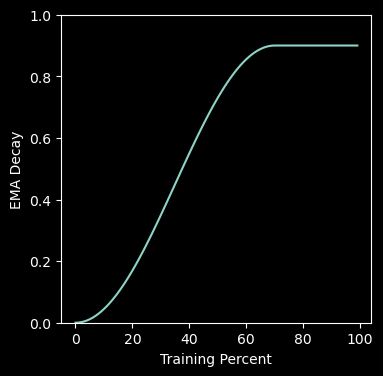

In [ ]:
#|hide
with no_random():
    learn = synth_learner(cbs=[EMAWarmupCallback(start_decay=0., final_decay=0.9, finish=7), EMAWarmupTestCallback])
    learn.fit(10, 1e-3)

epoch,train_loss,valid_loss,time
0,6.998855,6.030475,00:00
1,6.066998,4.214025,00:00
2,5.047641,2.648184,00:00
3,4.090349,1.623784,00:00
4,3.280436,0.993746,00:00
5,2.620882,0.626170,00:00
6,2.092462,0.426360,00:00
7,1.672583,0.298734,00:00
8,1.340229,0.193292,00:00
9,1.076735,0.121550,00:00


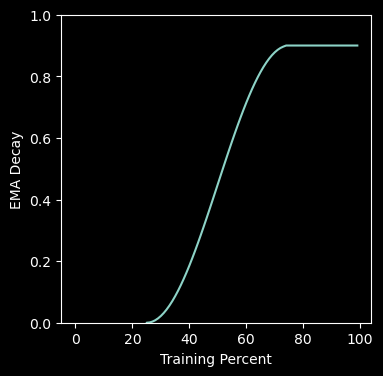

In [ ]:
#|hide
with no_random():
    learn = synth_learner(cbs=[EMAWarmupCallback(start_decay=0., final_decay=0.9, start=0.25, finish=0.75), EMAWarmupTestCallback])
    learn.fit(10, 1e-3)

In [ ]:
#|hide
#|slow
#|cuda
import time

from fastcore.basics import num_cpus

from fastai.data.external import URLs, untar_data
from fastai.data.block import DataBlock, CategoryBlock
from fastai.data.transforms import GrandparentSplitter, get_image_files, parent_label, Normalize
from fastai.learner import Learner
from fastai.vision.augment import Resize, aug_transforms
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageBlock
from fastai.vision.models import resnet18
from fastxtend.callback.channelslast import *

In [ ]:
#|hide
#|slow
#|cuda
imagenette = untar_data(URLs.IMAGENETTE_160)

with less_random():
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        splitter=GrandparentSplitter(valid_name='val'),
                        get_items=get_image_files, get_y=parent_label,
                        item_tfms=Resize(128),
                        batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])
    dls =  dblock.dataloaders(imagenette, bs=128, num_workers=num_cpus(), pin_memory=True)

    # EMATestCallback doesn't handle CancelStepException, so set `skip_ema=False` so results will match
    cbs = [EMACallback(start=2, skip_ema=False), EMATestCallback(start_epoch=2)]
    learn = Learner(dls, resnet18(num_classes=dls.c), cbs=cbs).to_channelslast()

    learn.fit(5, 1e-3)
    for fxt, timm in zip(learn.model_ema.parameters(), learn.ema_test.ema_model.module.parameters()):
        test_close(fxt, timm)
    for fxt, timm in zip(learn.model_ema.buffers(), learn.ema_test.ema_model.module.buffers()):
        test_close(fxt, timm)

epoch,train_loss,valid_loss,time
0,1.576827,1.755899,00:10
1,1.283530,1.395051,00:08
2,1.102556,1.368891,00:08
3,1.009172,1.343379,00:09
4,0.917506,1.311643,00:09
